###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

2024-05-26 14:26:35.627486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(1337)
random.seed(1337)

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
# Загрузка данных MNIST
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
X_train = X_train.astype('float64') / 255.0
X_test = X_test.astype('float64') / 255.0

# Изменение формы данных
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# One-hot кодирование меток
# y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

# y_train_oh

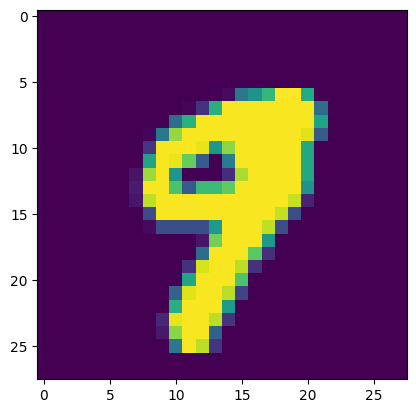

In [5]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(X_train)

In [6]:
from collections import defaultdict

POSITIVE_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def oh_encode(y, classes):
    NEG = 0.0
    GREY = 0.0
    POS = 1.0

    noise = np.array([GREY] * len(classes))

    oh_enc = defaultdict(lambda: noise)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(classes):
        cls_vec = np.array([NEG] * len(classes))
        cls_vec[i] = POS
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    def oh_decode(values):
        # pick the closest vector (is round() OK for that?)
        encoded = tuple(np.array([v.data for v in values]).round())
        return oh_dec[encoded]

    return oh_decode, np.array([oh_enc[cls] for cls in y])

OH_DECODER, Y_oh = oh_encode(Y_train, POSITIVE_CLASSES)
Y_oh.shape

(60000, 10)

In [7]:
def get_batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]
    return X, Y_oh


def arr2vals(array, name):
    return [[Value(el, _name=name) for el in row] for row in array]


def batch2vals(batch):
    return tuple(map(arr2vals, batch))

In [8]:
def accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += OH_DECODER(score) == OH_DECODER(ground_truths)

    return matches / len(scores)


def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth)) ** 0.5


def loss(scores, Y_oh):
    return sum(one_loss(xs, ys) for xs, ys in zip(scores, Y_oh)) / len(Y_oh)


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X_b, Y_b):
    input = arr2vals(X_b, 'input')
    scores = feed_forward(model, input)
    expected = arr2vals(Y_b, 'expected')
    return loss(scores, expected), accuracy(scores, expected)

(1, 784)

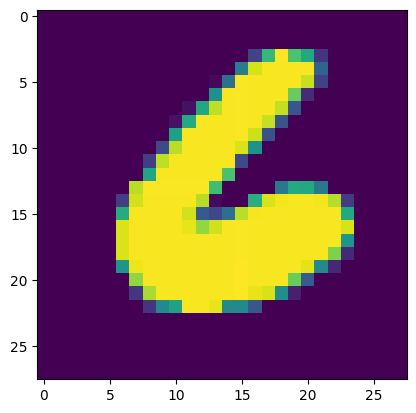

In [9]:
# train the model
BATCH_SIZE = 1
X_b, Y_b = get_batch(X_train, Y_oh, BATCH_SIZE)

draw_some(X_b)
X_b.shape

In [10]:
# initialize a model
model = MLP(
    784,
    [
        (10, 'sigmoid')
    ],
    lr=0.1
)
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [sigmoid-Neuron(784), sigmoid-Neuron(784), sigmoid-Neuron(784), sigmoid-Neuron(784), sigmoid-Neuron(784), sigmoid-Neuron(784), sigmoid-Neuron(784), sigmoid-Neuron(784), sigmoid-Neuron(784), sigmoid-Neuron(784)]]
number of parameters 7850


In [11]:
ITERATIONS = 100

# optimization loop
for k in range(ITERATIONS):
    total_loss, acc = evaluate(model, X_b, Y_b)
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
    if total_loss.data == 0:
        print("Early stop!")
        break

    model.learn_from(total_loss, q=0.5)

total_loss, acc = evaluate(model, X_b, Y_b)
print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.9792541299982223, accuracy 0.0%
step 1 loss 1.8380554014531532, accuracy 0.0%
step 2 loss 1.68551710490433, accuracy 0.0%
step 3 loss 1.489924185867363, accuracy 0.0%
step 4 loss 1.3903763746564324, accuracy 0.0%
step 5 loss 1.1409946603921939, accuracy 0.0%
step 6 loss 1.0037374726979187, accuracy 0.0%
step 7 loss 1.0023029769369873, accuracy 0.0%
step 8 loss 1.001503066460227, accuracy 0.0%
step 9 loss 1.0010076481772376, accuracy 0.0%
step 10 loss 1.0006846103812383, accuracy 0.0%
step 11 loss 1.0004677742188683, accuracy 0.0%
step 12 loss 1.0003195392587492, accuracy 0.0%
step 13 loss 1.0002168283029254, accuracy 0.0%
step 14 loss 1.0001447242368828, accuracy 0.0%
step 15 loss 1.0000931505553088, accuracy 0.0%
step 16 loss 1.0000548494772339, accuracy 0.0%
step 17 loss 1.0000236556690933, accuracy 0.0%
step 18 loss 0.9999911552498255, accuracy 0.0%
step 19 loss 0.9999279377219522, accuracy 0.0%
step 20 loss 0.9993375134222968, accuracy 0.0%
step 21 loss 0.005645572169

# DEBUG

In [12]:
input = arr2vals(X_b, 'input')
scores = feed_forward(model, input)
scores[0]

[Value(auto : [3.200110025054893e-17, 0]),
 Value(auto : [3.115187544156421e-17, 0]),
 Value(auto : [3.200110025055075e-17, 0]),
 Value(auto : [3.115083081844267e-17, 0]),
 Value(auto : [3.200110025055029e-17, 0]),
 Value(auto : [3.120031038414181e-17, 0]),
 Value(auto : [1.0, 0]),
 Value(auto : [3.200110025055029e-17, 0]),
 Value(auto : [3.115164299019708e-17, 0]),
 Value(auto : [3.1149874204640646e-17, 0])]

In [13]:
expected = arr2vals(Y_b, 'expected')
total_loss = loss(scores, expected)
total_loss.backward()
total_loss, [p for p in model.parameters() if p.grad > 0.0]

(Value(auto : [9.461127927054686e-17, 1]),
 [Value(weight : [-0.7543462413008664, 2.2072425981319344e-18]),
  Value(weight : [-0.30324571527810323, 7.215985416969785e-18]),
  Value(weight : [-0.2707937149372224, 1.078153115241368e-17]),
  Value(weight : [-0.5879119726827167, 7.76779606650277e-18]),
  Value(weight : [-0.6364337312129669, 6.579280821354804e-18]),
  Value(weight : [0.9632612723004988, 1.612984975557952e-18]),
  Value(weight : [0.8761080671541204, 4.5842730884278636e-18]),
  Value(weight : [-0.3624063479824065, 1.0187273529839697e-17]),
  Value(weight : [0.11785830045764635, 1.0739084179372681e-17]),
  Value(weight : [-0.5782072305839109, 1.0739084179372681e-17]),
  Value(weight : [0.3631137024319908, 1.0739084179372681e-17]),
  Value(weight : [-0.3586285464548288, 1.0739084179372681e-17]),
  Value(weight : [0.37577512757945297, 3.3957578432798988e-18]),
  Value(weight : [-0.4490255013806806, 2.1223486520499367e-19]),
  Value(weight : [0.8904467414528688, 3.990015465853881